# Titanic: Machine Learning from Disaster

## 1. Load and explore data

In [1]:
# Upload dataset
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# Info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
# Summary of each numerical attribute
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


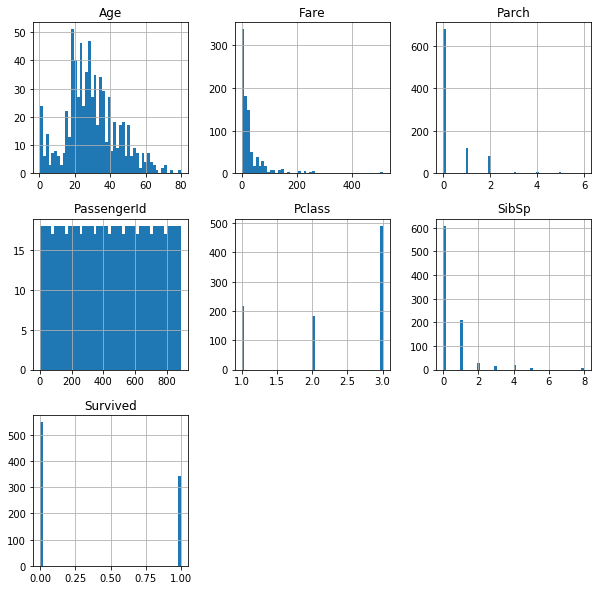

In [5]:
# Plot histogram for each numerical attribute
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(10,10))
plt.show()

In [6]:
# Correlations matrix
corr_matrix = train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

## 2. PREPARE DATA

In [7]:
## Data Cleaning
from sklearn.base import BaseEstimator, TransformerMixin
class AttributeRemover(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        remove_attribute = [
            "PassengerId", # Drop PassengerID (not relevant)
            "Name",        # Drop Name (not numeric feature)
            "Ticket",      # Drop Ticket (not numeric feature)
            "Cabin",       # Drop Cabin (>20% features missing)
        ]
        for attribute in remove_attribute:
            data = data.drop(attribute, axis=1)

        data = data.dropna(subset=["Embarked"]) # Drop 2 cases where value is NaN

        return data

## Handle text and categorical attributes
from sklearn.preprocessing import OrdinalEncoder
class AttributeConverter(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        convert_attribute = ["Sex", "Embarked"]
        ordinal_encoder = OrdinalEncoder()
        for attribute in convert_attribute:
            encoded = ordinal_encoder.fit_transform(data[[attribute]])
            data[[attribute]] = encoded
        return data

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
pipeline = Pipeline([
    ("attribute_remover", AttributeRemover()),
    ("attribute_converter", AttributeConverter()),
    ("imputer", SimpleImputer(strategy="median"))
    # ("std_scaler", StandardScaler())
])

prepared_train = pipeline.fit_transform(train)
y = prepared_train[:,0]
X = prepared_train[:,1:]

prepared_test = pipeline.fit_transform(test)

## 3. Train Model 

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X, y)

sgd_clf_scores = cross_val_score(sgd_clf, X, y, cv=10)
sgd_clf_scores.mean()

0.6962078651685393

In [9]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X, y)

svm_clf_scores = cross_val_score(svm_clf, X, y, cv=10)
svm_clf_scores.mean()

0.7087206332992849

In [10]:
from sklearn.ensemble import RandomForestClassifier
florest_clf = RandomForestClassifier(random_state=42)
florest_clf.fit(X, y)

florest_clf_scores = cross_val_score(florest_clf, X, y, cv=10)
florest_clf_scores.mean()

0.8144407558733402

In [11]:
# Submit prediction
import numpy as np
passengerId = test.iloc[:,0]
survived_predict = florest_clf.predict(prepared_test)
predictions = np.column_stack((passengerId, survived_predict)).astype(int)
df = pd.DataFrame(data=predictions, columns=["PassengerId","Survived"])
df.to_csv('submission.csv', index=False)